In [1]:
# Copyright 2019 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
# Visualization of the YAMNet audio event classification model.
# See https://github.com/tensorflow/models/tree/master/research/audioset/yamnet/
#
# This notebook can be run in Google Colab at https://colab.research.google.com
# by either downloading this ipynb and uploading it, or by looking up the
# notebook directly on GitHub in Colab's "Open notebook" dialog.

In [3]:
# Install required packages.
!pip install soundfile
!git clone https://github.com/tensorflow/models.git
%cd models/research/audioset/yamnet

# Download YAMNet data
!curl -O https://storage.googleapis.com/audioset/yamnet.h5

# Download audio for testing
!curl -O https://storage.googleapis.com/audioset/speech_whistling2.wav

!ls -l

Looking in indexes: https://artifacts.se.axis.com/artifactory/api/pypi/all-pypi/simple
  Using cached https://artifacts.se.axis.com/artifactory/api/pypi/all-pypi/packages/packages/44/6b/5edf93698ef1dc745774e47e26f5995040dd3604562dd63f5959fcd3a49e/cffi-1.15.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (427 kB)
  Using cached https://artifacts.se.axis.com/artifactory/api/pypi/all-pypi/packages/packages/62/d5/5f610ebe421e85889f2e55e33b7f9a6795bd982198517d912eb1c76e1a53/pycparser-2.21-py2.py3-none-any.whl (118 kB)
You should consider upgrading via the '/h/johana/Hands-On_Machine_Learning/2/venv/bin/python3 -m pip install --upgrade pip' command.
Cloning into 'models'...
remote: Enumerating objects: 74196, done.
remote: Counting objects: 100% (282/282), done.
remote: Compressing objects: 100% (178/178), done.
^Cceiving objects:  34% (25534/74196), 368.55 MiB | 2.49 MiB/s    
[Errno 2] No such file or directory: 'models/research/audioset/yamnet'
/h/johana/Hands-On_Machine_Learn

In [4]:
# Imports.
import numpy as np
import soundfile as sf

import matplotlib.pyplot as plt

import params as yamnet_params
import yamnet as yamnet_model
import tensorflow as tf

2022-06-04 21:02:04.144641: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-04 21:02:04.144655: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/h/johana/Hands-On_Machine_Learning/2/venv/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [27]:
# Read in the audio.
wav_file_name = 'speech_whistling2.wav'
wav_data, sr = sf.read(wav_file_name, dtype=np.int16)
waveform = wav_data / 32768.0



In [38]:
waveform_float32 = tf.cast(waveform, tf.float32)
with open(wav_file_name + '.float32', 'wb' ) as f:
  f.write(waveform_float32)
waveform_int16 = tf.cast(waveform*32768.0, tf.int16)
with open(wav_file_name + '.int16', 'wb' ) as f:
  f.write(waveform_int16)  

In [28]:
# Convert to 8 bit audio, just to compare precision
waveform_int8 = np.round(waveform * 256) / 256


In [6]:
# The graph is designed for a sampling rate of 16 kHz, but higher rates should work too.
# We also generate scores at a 10 Hz frame rate.
params = yamnet_params.Params(sample_rate=sr, patch_hop_seconds=0.1)
print("Sample rate =", params.sample_rate)

Sample rate = 16000


In [7]:
# Set up the YAMNet model.
class_names = yamnet_model.class_names('yamnet_class_map.csv')
yamnet = yamnet_model.yamnet_frames_model(params)
yamnet.load_weights('yamnet.h5')

2022-06-04 21:02:23.685773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-04 21:02:23.685787: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-04 21:02:23.685798: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: pc37481-1948
2022-06-04 21:02:23.685801: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: pc37481-1948
2022-06-04 21:02:23.685832: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2022-06-04 21:02:23.685849: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 418.211.0
2022-06-04 21:02:23.685977: I tensorflow/core/platform/cpu_feature_guard.cc:151] This

In [40]:
# Run the model.
scores, embeddings, spectrogram = yamnet(waveform)
scores = scores.numpy()
spectrogram = spectrogram.numpy()

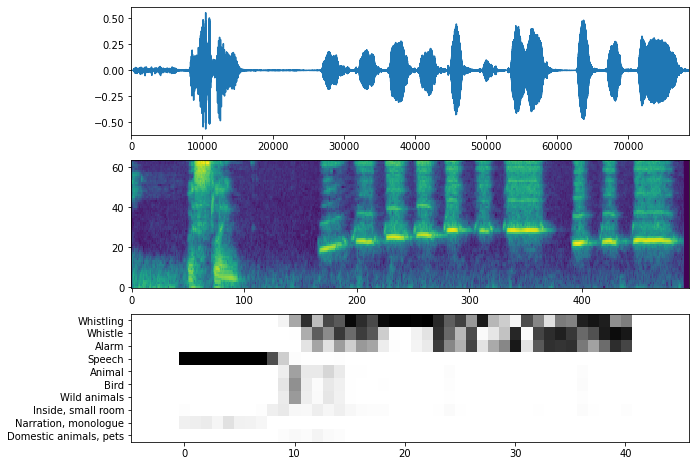

In [41]:
def visualize(waveform, spectogram, scores):
  # Visualize the results.
  plt.figure(figsize=(10, 8))

  # Plot the waveform.
  plt.subplot(3, 1, 1)
  plt.plot(waveform)
  plt.xlim([0, len(waveform)])
  # Plot the log-mel spectrogram (returned by the model).
  plt.subplot(3, 1, 2)
  plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='lower')

  # Plot and label the model output scores for the top-scoring classes.
  mean_scores = np.mean(scores, axis=0)
  top_N = 10
  top_class_indices = np.argsort(mean_scores)[::-1][:top_N]
  plt.subplot(3, 1, 3)
  plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
  # Compensate for the patch_window_seconds (0.96s) context window to align with spectrogram.
  patch_padding = (params.patch_window_seconds / 2) / params.patch_hop_seconds
  plt.xlim([-patch_padding, scores.shape[0] + patch_padding])
  # Label the top_N classes.
  yticks = range(0, top_N, 1)
  plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
  _ = plt.ylim(-0.5 + np.array([top_N, 0]))

visualize(waveform, spectrogram, scores)

2.8.0


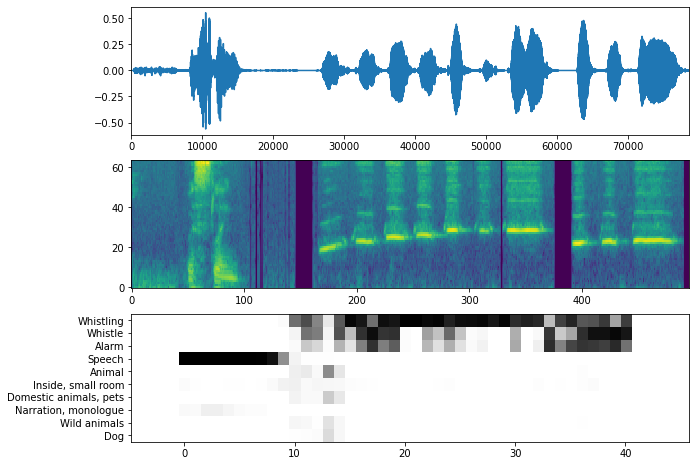

In [33]:
print(tf.__version__)
# Run the model.
scores, embeddings, spectrogram = yamnet(waveform_int8)
scores = scores.numpy()
spectrogram = spectrogram.numpy()
visualize(waveform_int8, spectrogram, scores)